# Titanic EDA(Explanatory Data Analysis)
- Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

## 1. Import libralies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data

In [2]:
# Load data
##### Load train and Test set

train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [3]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [4]:
# Show the outliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


### 2.3 joining train and test set

In [5]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.4 check for null and missing values

In [6]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [7]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

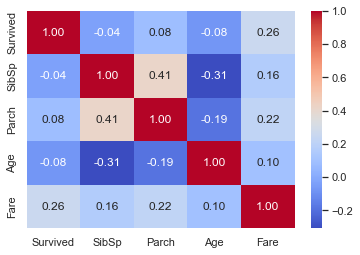

In [16]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

- Fare feature seems to have a significative correlation with the survival probability.

#### SibSP

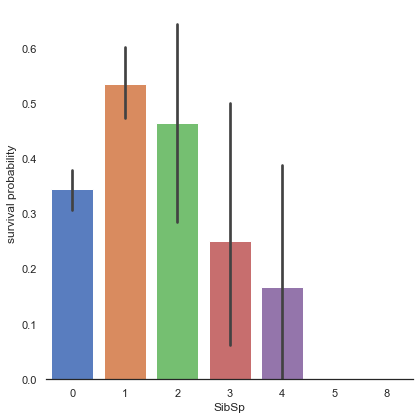

In [18]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

#### Parch

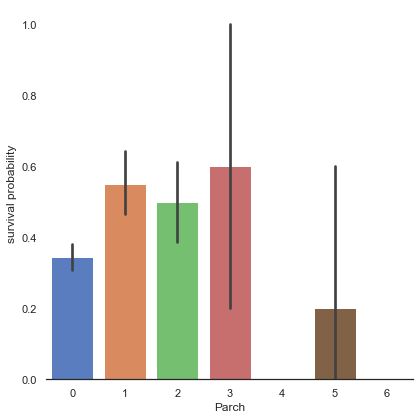

In [19]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

#### Age

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


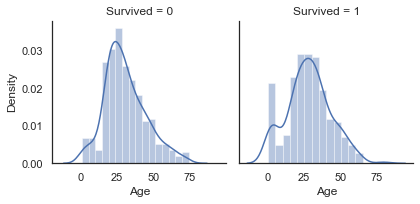

In [23]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

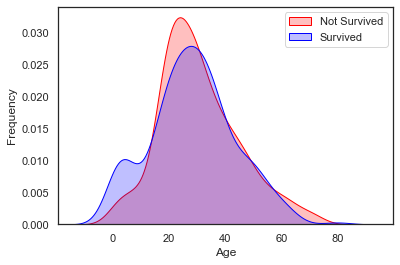

In [26]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

#### Fare

In [27]:
dataset["Fare"].isnull().sum()

1

- Since we have one missing value , i decided to fill it with the median value which will not have an important effect on the prediction.

In [28]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


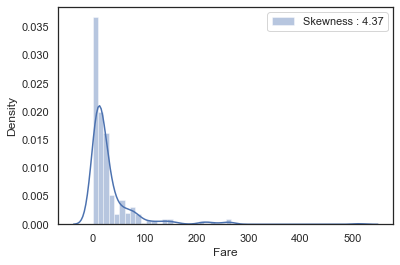

In [31]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

- In this case, it is better to transform it with the log function to reduce this skew.

In [32]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


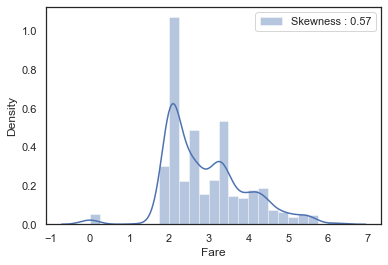

In [33]:
g = sns.distplot(dataset["Fare"], label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- Skewness is clearly reduced after the log transformation

### 3.2 Categorical values

#### Sex

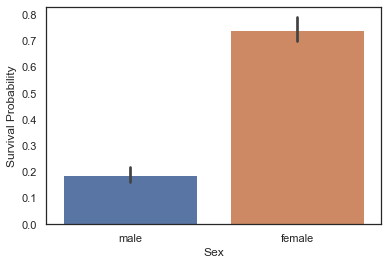

In [36]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel("Survival Probability")

In [37]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


- It is clearly obvious that Male have less chance to survive than Female.
- So Sex, might play an important role in the prediction of the survival.
- For those who have seen the Titanic movie (1997), I am sure, we all remember this sentence during the evacuation : "Women and children first".

#### Pclass

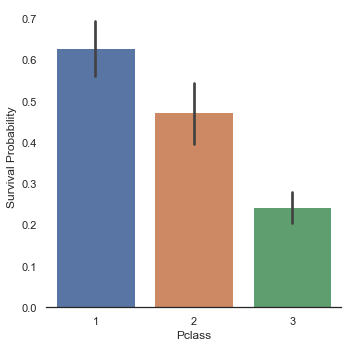

In [44]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass", y="Survived", data=train, kind='bar')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

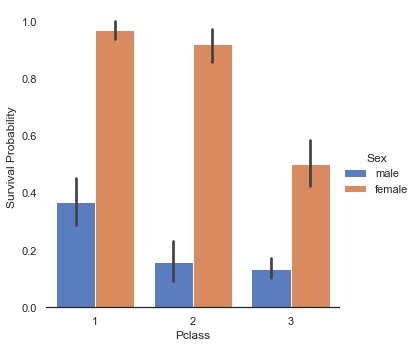

In [48]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

- The passenger survival is not the same in the 3 classes.
    - First class passengers have more chance to survive than second class and third class passengers.
- This trend is conserved when we look at both male and female passengers.

#### Embarked
- Since we have two missing values , i decided to fill them with the most fequent value of "Embarked" (S).

In [49]:
dataset["Embarked"].isnull().sum()

2

In [51]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

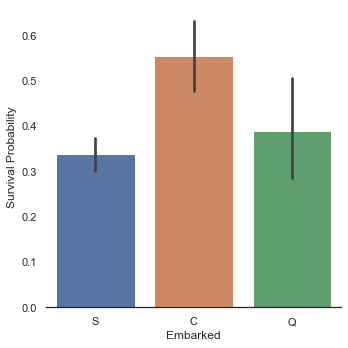

In [57]:
# Explore Embarked vs Survived
g = sns.catplot(x="Embarked", y="Survived", data=train, kind="bar")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

- It seems that passenger coming from Cherbourg (C) have more chance to survive.
- My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).
- Let's see the Pclass distribution vs Embarked

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


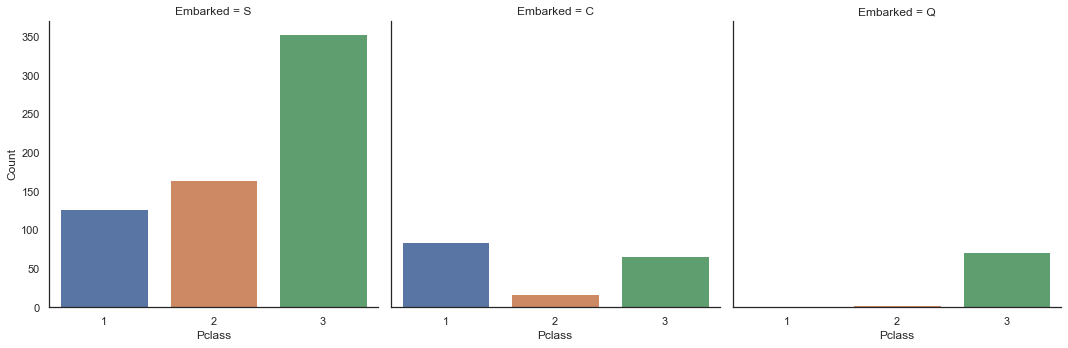

In [59]:
# Explore Pclass vs Embarked 
g = sns.catplot("Pclass", col="Embarked", data=train, kind="count")
g = g.set_ylabels("Count")

- Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.
- At this point, i can't explain why first class has an higher survival rate.
- My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

## 4.Filling missing Values

In [61]:
dataset["Age"].isnull().sum()

263

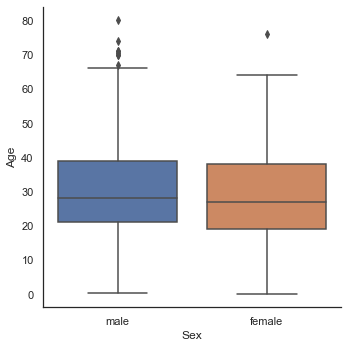

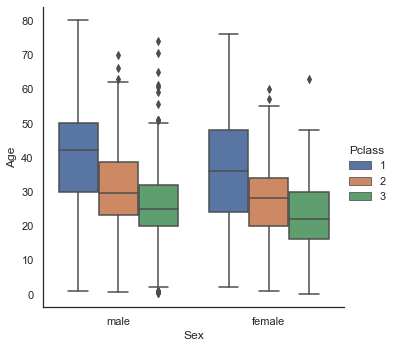

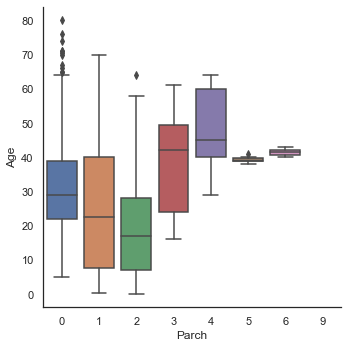

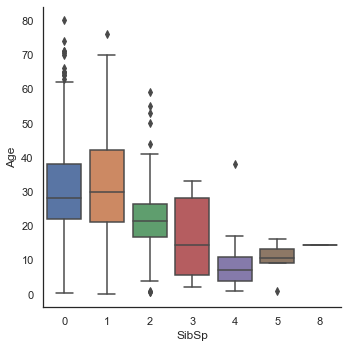

In [63]:
g = sns.catplot(y="Age", x="Sex", data=dataset, kind="box")
g = sns.catplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g = sns.catplot(y="Age", x="Parch", data=dataset, kind="box")
g = sns.catplot(y="Age", x="SibSp", data=dataset, kind="box")

- Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.
- However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.
- Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [64]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

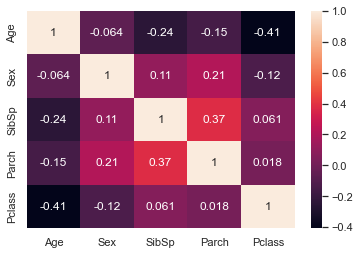

In [66]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), annot=True)

- The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.
- In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.
- So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.
- The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.

In [70]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"]) & (dataset["Parch"] == dataset.iloc[i]["Parch"]) & (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()

    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med


/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

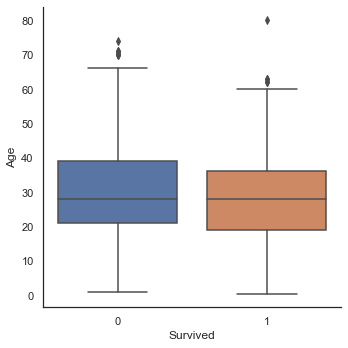

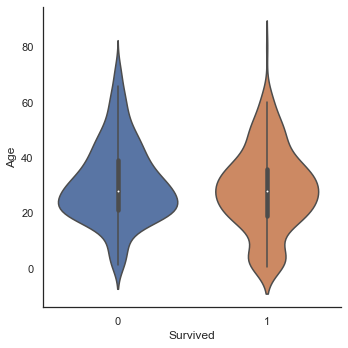

In [71]:
g = sns.catplot(x="Survived", y="Age", data=train, kind="box")
g = sns.catplot(x="Survived", y="Age", data=train, kind="violin")

- No difference between median value of age in survived and not survived subpopulation.
- But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

## 5.Feature engineering

### 5.1 Name/Title

In [72]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- The Name feature contains information on passenger's title.
- Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [86]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

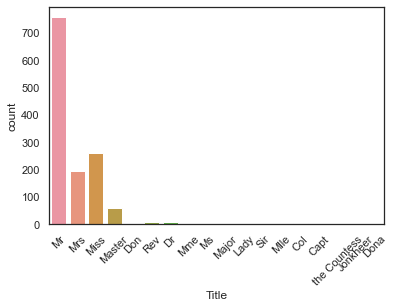

In [87]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

- There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [88]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})
dataset["Title"] = dataset["Title"].astype(int)

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


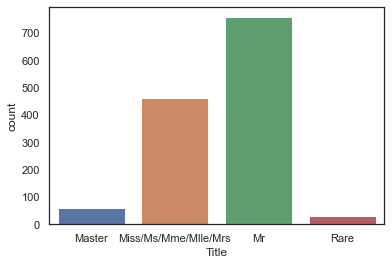

In [90]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

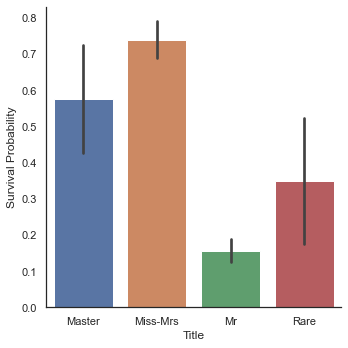

In [91]:
g = sns.catplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("Survival Probability")

- "Women and children first"
- It is interesting to note that passengers with rare title have more chance to survive.

In [92]:
# Drop Name variable
dataset.drop(labels=["Name"], axis=1, inplace=True)

### 5.2 Family Size
- We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation.
- So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [93]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

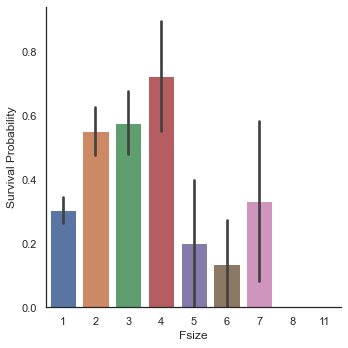

In [95]:
g = sns.catplot(x="Fsize", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

- The family size seems to play an important role, survival probability is worst for large families.
- Additionally, i decided to created 4 categories of family size.

In [96]:
# Create new feature of family size
dataset["Single"] = dataset["Fsize"].map(lambda x: 1 if x == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda x: 1 if x == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda x: 1 if 3 <= x <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda x: 1 if x >= 5 else 0)

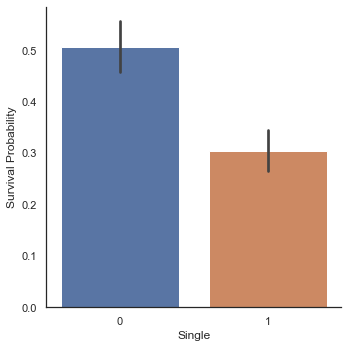

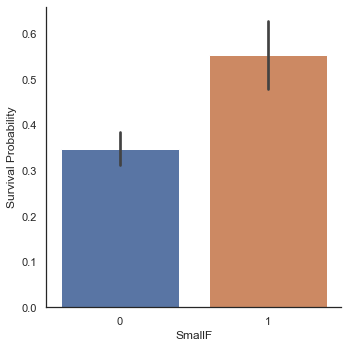

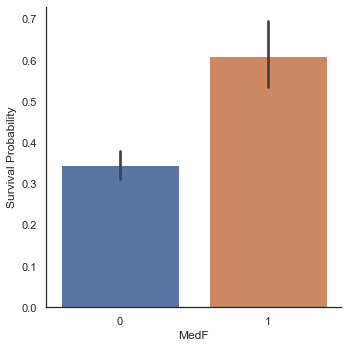

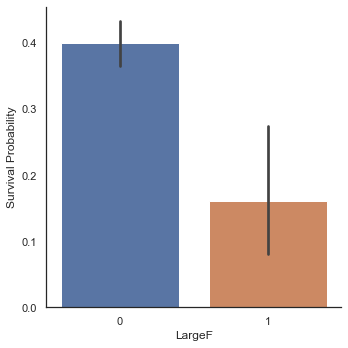

In [97]:
g = sns.catplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

- Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [98]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [99]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [100]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [101]:
dataset["Cabin"].describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

In [102]:
dataset["Cabin"].isnull().sum()

1014

In [103]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [104]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset["Cabin"]])

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


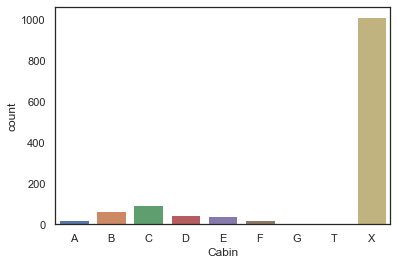

In [106]:
g = sns.countplot(dataset["Cabin"], order=["A", "B", "C", "D", "E", "F", "G", "T", "X"])

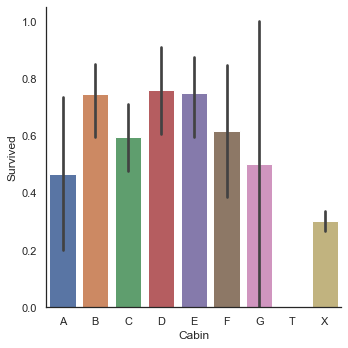

In [107]:
g = sns.catplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=["A", "B", "C", "D", "E", "F", "G", "T", "X"])

- Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.
- But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).
- It is particularly true for cabin B, C, D, E and F.

In [108]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin")

### 5.4 Ticket

In [109]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.
- Tickets with same prefixes may have a similar class and survival.
- So i decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [110]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [111]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [112]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc")

In [113]:
# Drop useless variables
dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [114]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6.Save preprocessed dataset

In [115]:
## Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [117]:
train.to_csv("../data/processed/train.csv")
test.to_csv("../data/processed/test.csv")